<a href="https://colab.research.google.com/github/lucascarter0/data-science-tools/blob/master/Covid19_Modeling_MCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting of COVID-19 Pandemic Using Markov-Chain Monte Carlo

The goal of this analysis is to create an epidemiological forecast of COVID-19 transmission using infectious disease models that have been fitted to COVID-19 test results. This analysis seeks to address the following questions:
- How well do early prediction models used to make quarantine policy recommendations reflect data that has since been measured?
- How well are quarantine measures slowing the spread of the virus?

A susceptible, infected, removed (SIR) model will be tuned to estimate performance characteristics of the virus using Markov Chain Monte Carlo (MCMC). 


In [0]:
# Importing needed libraries
!pip install pymc3==3.8
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd


     |████████████████████████████████| 911kB 2.8MB/s 
     |████████████████████████████████| 1.5MB 16.5MB/s 
     |████████████████████████████████| 4.1MB 24.0MB/s 
     |████████████████████████████████| 327kB 39.8MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


# Data Collection

Data used for this analysis comes from the COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University (https://github.com/CSSEGISandData/COVID-19). The repository contains time history and data summary entries at the global level and United States county level.

My initial goal was to create a model using US county data, but it appears that recovered cases have not been recorded. The code below combines daily reports from March 22nd to May 9th and creates a single dataframe of confirmed, recovered, and active cases, as well as deaths.

In [0]:
from datetime import timedelta, date
import os


def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

def load_county_data(index='Dallas, Texas, US'):

  df = pd.DataFrame(columns=['Confirmed','Deaths','Recovered','Active'])
  start_date = date(2020, 3, 22)
  end_date = date(2020, 5, 11)
  dates = [ii.strftime('%m-%d-%Y') for ii in daterange(start_date, end_date)]

  for single_date in dates:
      #day = single_date.strftime('%m-%d-%Y')
      basepath = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports'
      url = os.path.join(basepath, '{}.csv'.format(single_date))

      a = pd.read_csv(url, index_col=-1, usecols=['Confirmed','Deaths','Recovered','Active', 'Combined_Key'])

      df.loc[single_date] = a.loc[index]
  df.index = pd.to_datetime(df.index)
  return df.astype('float64')

df = load_county_data()
df.tail()

,Confirmed,Deaths,Recovered,Active
2020-05-06,4869.0,123.0,0.0,4746.0
2020-05-07,5120.0,125.0,0.0,4995.0
2020-05-08,5369.0,135.0,0.0,5234.0
2020-05-09,5619.0,143.0,0.0,5476.0
2020-05-10,5870.0,143.0,0.0,5727.0


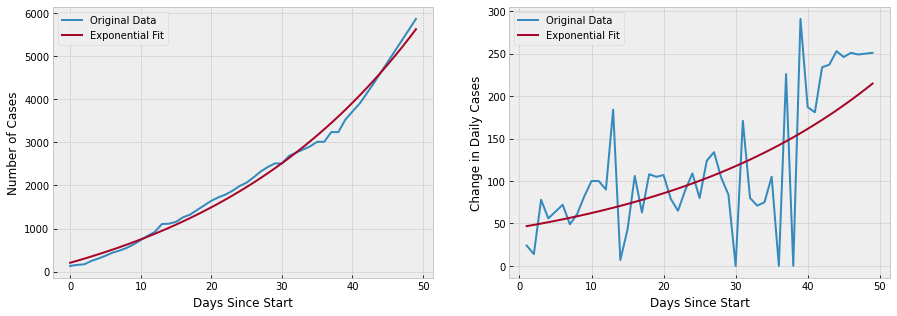

In [0]:
%matplotlib inline
plt.style.use('bmh')

# Exponential smoothing
from scipy.optimize import curve_fit

def func(x, a, b, c):
  return a*np.exp(-b*x) + c

s = df['Confirmed'].astype('float64')
x = np.arange(0, len(s))
y = s.values

popt, _ = curve_fit(func, x, y)

yy = func(x, *popt)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1.plot(x, s.values, label='Original Data')
ax1.plot(x, yy, label='Exponential Fit')
ax1.set_ylabel('Number of Cases')

ax2.plot(x[1:], np.diff(s.values), label='Original Data')
ax2.plot(x[1:], np.diff(yy), label='Exponential Fit')
ax2.set_ylabel('Change in Daily Cases')

for ax in [ax1, ax2]:
  ax.set_xlabel('Days Since Start')
  ax.legend(loc='upper left')


Defining prior distributions
Defining observation model


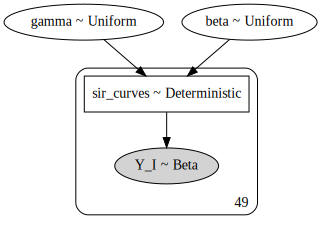

In [0]:
from scipy.integrate import odeint
import theano
import theano.tensor as t

# Normalize exponentially smoothed esimate for population of county
yobs = yy / 2636000
times = np.arange(start=1, stop=len(yobs), step=1, dtype='float64')
y0 = np.array([(1-yobs[0]), yobs[0]])

# Define SIR dynamics
def SIR(y, t, p):

    ds = -p[0]*y[0]*y[1]
    di = p[0]*y[0]*y[1] - p[1]*y[1]
    dr = p[1]*y[1]
    return [ds, di]


# Add PYMC3 ODE wrapper for SIR Dynamics
#sir_model = DifferentialEquation(
#    func=SIR,
#    times=np.arange(1,len(yobs)),
#    n_states=2,
#    n_theta=2,
#    t0=0)



@theano.compile.ops.as_op(itypes=[t.dvector, t.dvector, t.dscalar, t.dscalar], otypes=[t.dvector])
def sir_model_wrapper(time_span, initial_conditions, beta, gamma):

    y_model = odeint(SIR, t=time_span, y0=initial_conditions, args=((beta,gamma),), rtol=1e-8)

    return y_model[:,1]


with pm.Model() as model:

  # Using relatively uninformed priors for parameters of SIR dynamics
  print('Defining prior distributions')
  gamma = pm.Uniform('gamma', lower=0.001, upper=0.3)
  beta = pm.Uniform('beta', lower=0.1, upper=20)
  #S0 = pm.Uniform('S0', lower=0.1, upper=1)

  #sir_curves = sir_model(y0=[S0, yobs[0], 1-S0-yobs[0]], theta=[beta, gamma])
  #sir_curves = sir_model(y0=[(1-yobs[0]), yobs[0]], theta=[beta, gamma])

  # Defining the deterministic formulation of the problem
  sir_curves = pm.Deterministic('sir_curves', sir_model_wrapper(
        theano.shared(times), 
        theano.shared(y0),
        beta,
        gamma))

  # Observations follow beta distribution. Alpha, beta based on SIR dynamics
  print('Defining observation model')
  Y_I = pm.Beta('Y_I', 
                alpha=sir_curves, 
                beta=(1-sir_curves), 
                observed=yobs[1:])

pm.model_to_graphviz(model)


In [51]:
with model:
  step = pm.Metropolis()
  trace = pm.sample(10000, tune=1000, cores=4, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [gamma]
Sampling 4 chains, 0 divergences: 100%|██████████| 44000/44000 [10:43<00:00, 68.41draws/s]
The number of effective samples is smaller than 10% for some parameters.


(array([9.2300e+02, 1.1942e+04, 1.5642e+04, 6.6690e+03, 2.6590e+03,
        1.0830e+03, 3.5800e+02, 1.8300e+02, 3.7000e+01, 4.0000e+00]),
 array([0.06185982, 0.07486336, 0.0878669 , 0.10087044, 0.11387399,
        0.12687753, 0.13988107, 0.15288461, 0.16588816, 0.1788917 ,
        0.19189524]),
 <a list of 10 Patch objects>)

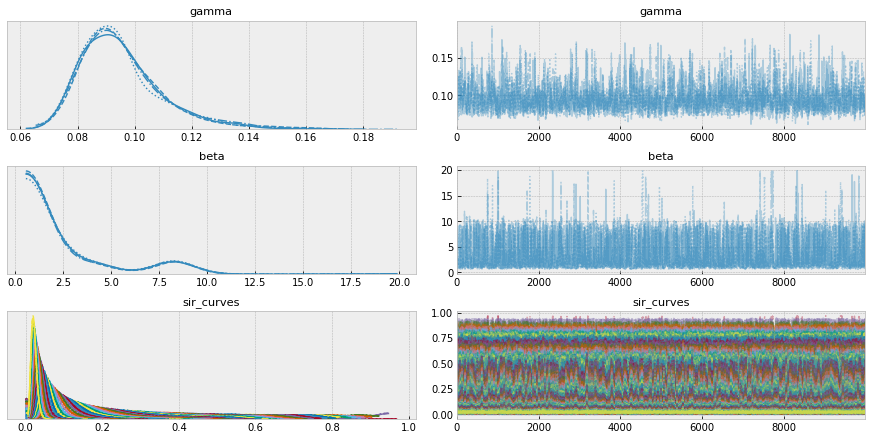

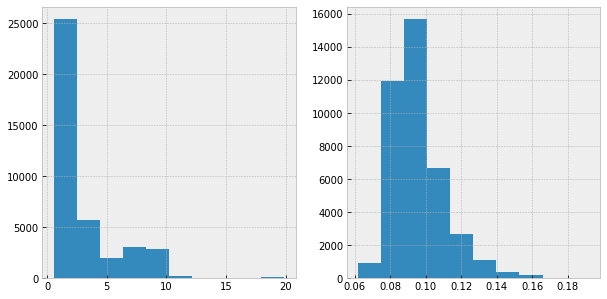

In [52]:
pm.traceplot(trace)

beta = trace['beta'][:, None]
gamma = trace['gamma'][:, None]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax1.hist(beta[500:])
ax2.hist(gamma[500:])

### Nationwide Data Collection
Until it can be confirmed that the "recovered" values are correct, I will focus on building models with nationwide values. The first country I will look at is Sweden. Sweden has taken a controversial approach to containing the spread of coronavirus and has opted to keep its businesses open and encourage social responsibility instead of imposing strict quarantine measures.

JHU has three different time series CSV files, each indexed by country:
- Total confirmed cases
- Total recovered cases
- Total deaths

To use these values in the context of an SIR model, I have combined deaths and recovered cases to create a series of "removed" cases. Each value is then divided by the total population to represent each value as a proportion.

In [0]:
def get_JHU_series(url, country, start_date):

  # Index on country name
  s = pd.read_csv(url, index_col=1)
  s = s.loc[country]
  # Drop indices of series that are not dates
  s = s.drop(['Province/State','Lat', 'Long'])
  # Convert index to DateTime
  s.index = pd.to_datetime(s.index, infer_datetime_format=True)

  # Return dates starting from start date
  return s.loc[start_date:]


def create_dataframe(country, start_date, 
                     population=1, max_susceptible=1):

    url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    infected = get_JHU_series(url, country, start_date)
    
    url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
    recovered = get_JHU_series(url, country, start_date)
    
    url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
    deaths = get_JHU_series(url, country, start_date)

    # Day to day new cases
    new_cases = infected.diff()
    
    # Removed defined as recovered or dead
    removed = (recovered + deaths)    
    df = pd.concat([infected, new_cases, removed], axis=1)
    
    # Normalize for population
    df = df / population
    
    df.columns = ['infected', 'daily_new_cases', 'removed']
    # Susceptible column is however many people are at risk of catching the virus
    # S + I + R = max_susceptiblei
    df['susceptible'] = max_susceptible - df['infected'] - df['removed']
    return df



# populations estimated from Eurostat
sweden = create_dataframe(
    country='Sweden', start_date='2020-2-23', population=10230200)


### Data Analysis
Initial plots of the data recreate what's reported by the JHU's daily tracking web app. Additionally, the data *appears* to follow the theoretical behavior of an unimpeded SIR model, especially when compared against Norway, Sweden's neighboring country that has imposed very strict quarantine measures to slow the spread of the virus.

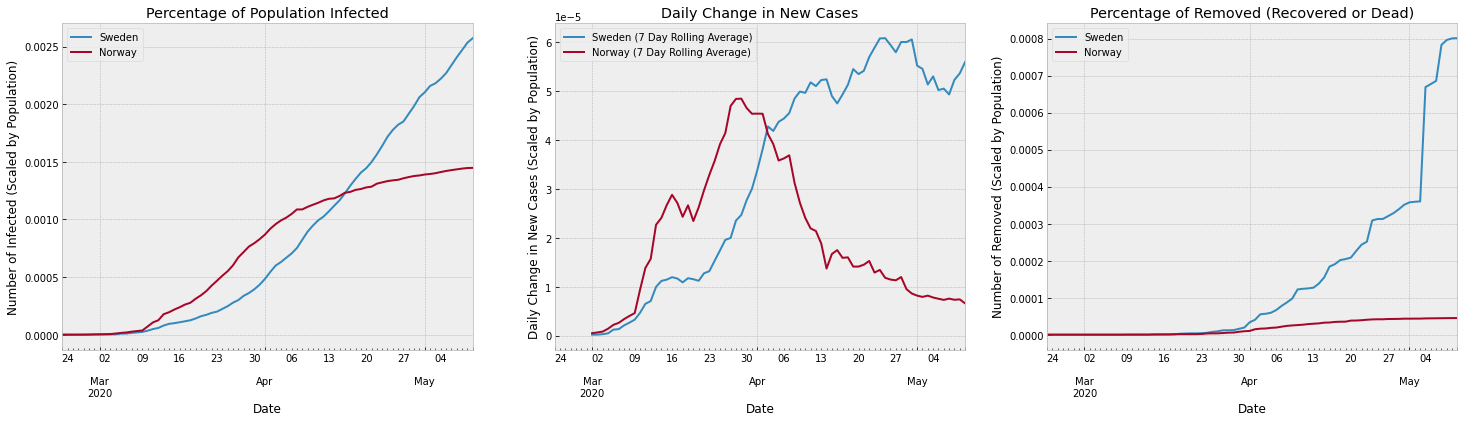

In [0]:
norway = create_dataframe(country='Norway', start_date='2020-2-23', population=5600000)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,6))

sweden['infected'].plot(ax=ax[0], label='Sweden')
norway['infected'].plot(ax=ax[0], label='Norway')
ax[0].set_title('Percentage of Population Infected')
ax[0].set_ylabel('Number of Infected (Scaled by Population)')

sweden['daily_new_cases'].rolling(window=7).mean().plot(
    ax=ax[1], label='Sweden (7 Day Rolling Average)')
norway['daily_new_cases'].rolling(window=7).mean().plot(
    ax=ax[1], label='Norway (7 Day Rolling Average)')
ax[1].set_title('Daily Change in New Cases')
ax[1].set_ylabel('Daily Change in New Cases (Scaled by Population)')

sweden['removed'].plot(ax=ax[2], label='Sweden')
norway['removed'].plot(ax=ax[2], label='Norway')
ax[2].set_title('Percentage of Removed (Recovered or Dead)')
ax[2].set_ylabel('Number of Removed (Scaled by Population)')

for subax in ax:
  subax.set_xlabel('Date')
  subax.legend()

To forecast the future spread of the virus for both countries, I will attempt to estimate the parameters of an SIR model for each country using MCMC and the available data collected above, then extrpolate that model forward in time.

# SIR Model

TODO: Add description of SIR Model

# MCMC

TODO: Add description of MCMC algorithm

In [0]:
import numpy as np
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import theano.tensor as tt

# Interested in the first two weeks
yobs = sweden['infected'].to_numpy(dtype='float64')
yobs = yobs[14:25]

def SIR(y, t, p):
    ds = -p[0]*y[0]*y[1]
    di = p[0]*y[0]*y[1] - p[1]*y[1]
    dr = p[1]*y[1]
    return [ds, di, dr]


sir_model = DifferentialEquation(
    func=SIR,
    times=np.arange(1,11),
    n_states=3,
    n_theta=2,
    t0=0)


with pm.Model() as model:
    
    R0 = pm.Lognormal('R0', mu=1.099, tau=0.096)
    print('gamma')
    gamma = pm.Lognormal('gamma', mu=-2.955, tau=0.910)
    print('beta')
    beta = pm.Deterministic('beta', gamma*R0)
    
    k = pm.Gamma('K', alpha=2, beta=0.0001)
    lambda_I = pm.Gamma('lambda_I', alpha=2, beta=0.0001)
    theta_0 = pm.Dirichlet('theta_0',np.array([0.99, yobs[0], (1-0.99-yobs[0])]))

    print('sir')
    sir_curves = sir_model(y0=theta_0,theta=[beta, gamma])
    print('theta')
    theta = pm.Dirichlet('theta',a=k*sir_curves, shape=(10,3))

    Y_I = pm.Beta('Y_I',alpha=lambda_I*theta[:,1], beta=lambda_I*(1-theta[:,1]), observed=yobs[1:])

gamma
beta
sir
theta


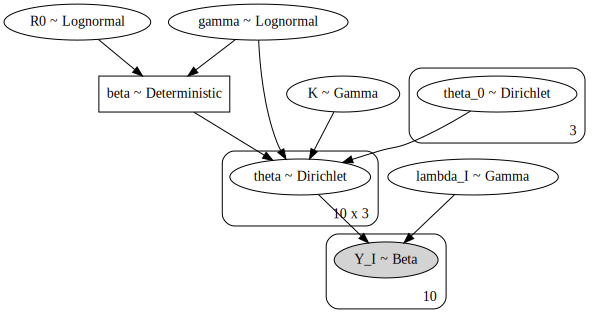

In [0]:

#posterior_predictive = pm.sample_posterior_predictive(trace)

pm.model_to_graphviz(model)

#data = az.from_pymc3(trace=trace, prior = prior, posterior_predictive = posterior_predictive)

In [0]:
with model:
    prior = pm.sample_prior_predictive()
    trace = pm.sample(2000,tune=1000, target_accept=0.9, cores=4)
    posterior_predictive = pm.sample_posterior_predictive(trace)

/usr/local/lib/python3.6/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


ValueError: ignored

In [0]:
with model:
    #prior = pm.sample_prior_predictive()
    #trace = pm.sample(2000,tune=1000, target_accept=0.9, cores=4)
    trace = pm.sample(cores=2)
    #posterior_predictive = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, gamma]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [18:47<00:00,  1.77draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8ebb5f29e8>,
      dtype=object)

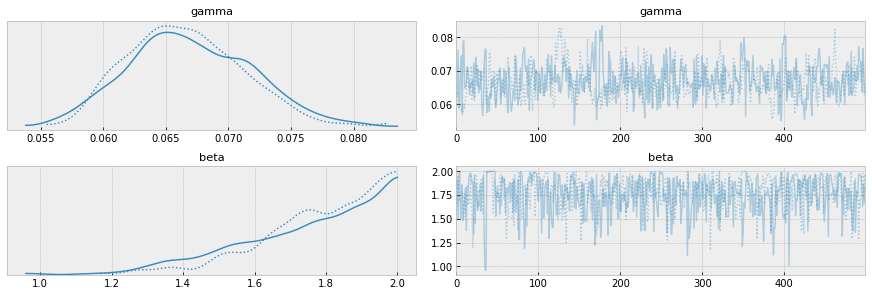

In [0]:
pm.traceplot(trace)